In [7]:
import pdb
import h5py
import time
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('__file__')))))
import yaml
import numpy as np
np.random.seed(1738)
import pickle
import pandas as pd
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import fitsio
import datetime
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
#from compute_nz import wl_selection
#from utils import mag2flux, flux2mag, printlog
from astropy.table import Table,join
from astropy.table import Table
import esutil as eu
#from sompz import CellMap
from math import log10
%matplotlib inline

In [8]:
snmin=10
snmax=300
sizemin=0.5
sizemax=5
steps=20

def assign_loggrid(x, y, xmin, xmax, xsteps, ymin, ymax, ysteps):
    # return x and y indices of data (x,y) on a log-spaced grid that runs from [xy]min to [xy]max in [xy]steps
    
    logstepx = log10(xmax/xmin)/xsteps
    logstepy = log10(ymax/ymin)/ysteps
    
    indexx = (np.log10(x/xmin)/logstepx).astype(int)
    indexy = (np.log10(y/ymin)/logstepy).astype(int)
    
    indexx = np.maximum(indexx,0)
    indexx = np.minimum(indexx, xsteps-1)
    indexy = np.maximum(indexy,0)
    indexy = np.minimum(indexy, ysteps-1)
    
    return indexx,indexy

def apply_loggrid(x, y, grid, xmin=snmin, xmax=snmax, xsteps=steps, ymin=sizemin, ymax=sizemax, ysteps=steps):
    indexx,indexy = assign_loggrid(x, y, xmin, xmax, xsteps, ymin, ymax, ysteps)
    res = np.zeros(len(x))
    res = grid[indexx,indexy]
    return res

def logmeshplot(data, xedges, yedges, label="quantity"):
    X, Y = np.meshgrid(yedges, xedges)
    plt.pcolormesh(X, Y, data)
    plt.xscale('log')
    plt.yscale('log')
    plt.colorbar(label=label)
    plt.ylabel("mcal snr")
    plt.xlabel("mcal size/psf_size")
    
def mesh_average(quantity,indexx,indexy,steps,count):
    m = np.zeros((steps,steps)) # revised version, was -1 before
    np.add.at(m,(indexx,indexy),quantity)
    m /= count
    return m

In [9]:
# step 1 - prepare weight on a grid of snr and size_ratio

mastercat = '/global/cscratch1/sd/troxel/cats_des_y3/Y3_mastercat_03_31_20.h5'
f = h5py.File(mastercat,'r') # this is the master catalog
print("read select")

read select


In [10]:
select = np.array(f['index']['select'])

# re-scale SNR and revise selection; don't do that after it's been fixed in the catalog `snr` and `select` columns
print("read snr")
new_snr=np.array(f['catalog/metacal/unsheared/snr'])[select]
print("read size")
new_size_ratio=np.array(f['catalog/metacal/unsheared/size_ratio'])[select]
new_T=np.array(f['catalog/metacal/unsheared/T'])[select]
print("read R")
new_R11=np.array(f['catalog/metacal/unsheared/R11'])[select]
new_R22=np.array(f['catalog/metacal/unsheared/R22'])[select]
print("read e")
new_e1=np.array(f['catalog/metacal/unsheared/e_1'])[select]
new_e2=np.array(f['catalog/metacal/unsheared/e_2'])[select]
print("read weight")
new_weight=np.array(f['catalog/metacal/unsheared/weight'])[select]
print("read RA,dec")
new_ra=np.array(f['catalog/metacal/unsheared/ra'])[select]
new_dec=np.array(f['catalog/metacal/unsheared/dec'])[select]
f.close()

read snr
read size
read R
read e
read weight
read RA,dec


In [11]:
snmin=10
snmax=300
sizemin=0.5
sizemax=5
steps=20

new_indexx,new_indexy = assign_loggrid(new_snr, new_size_ratio, snmin, snmax, steps, sizemin, sizemax, steps)
new_count = np.zeros((steps,steps))
np.add.at(new_count,(new_indexx,new_indexy), 1)

In [12]:
H, xedges, yedges = np.histogram2d(new_snr, new_size_ratio, bins=[np.logspace(log10(snmin),log10(snmax),steps+1), np.logspace(log10(sizemin),log10(sizemax),steps+1)])

<Figure size 432x288 with 0 Axes>

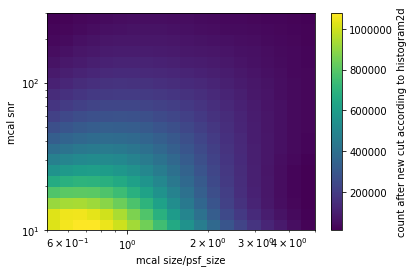

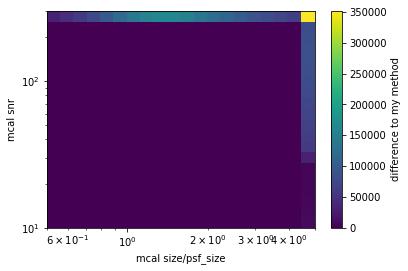

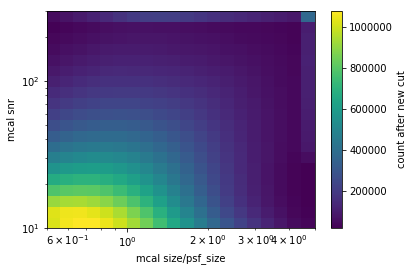

<Figure size 432x288 with 0 Axes>

In [13]:
logmeshplot(H, xedges, yedges, "count after new cut according to histogram2d")
plt.figure()
logmeshplot(new_count-H, xedges, yedges, "difference to my method")
plt.figure()
logmeshplot(new_count, xedges, yedges, "count after new cut")
plt.figure()

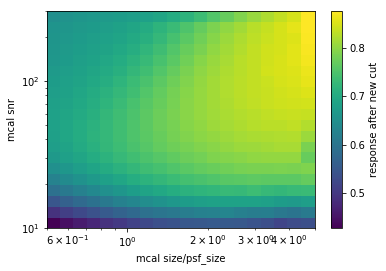

In [14]:
new_response = mesh_average((new_R11+new_R22)/2,new_indexx,new_indexy,steps,new_count)
#old_response = mesh_average((old_R11+old_R22)/2,old_indexx,old_indexy,steps,old_count)

logmeshplot(new_response, xedges, yedges, "response after new cut")

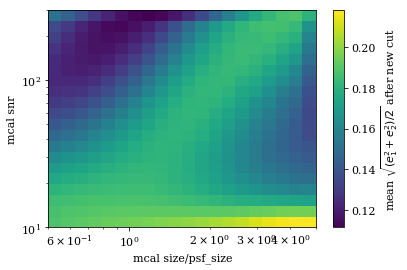

In [44]:
#old_meanes = mesh_average(np.sqrt(old_e1**2+old_e2**2)/2,old_indexx,old_indexy,steps,old_count)
new_meanes = mesh_average(np.sqrt((new_e1**2+new_e2**2)/2),new_indexx,new_indexy,steps,new_count)
#logmeshplot(old_meanes, xedges, yedges, r"mean $\sqrt{e_1^2+e_2^2}/2$ before new cut")
#plt.figure()
logmeshplot(new_meanes, xedges, yedges, r"mean $\sqrt{(e_1^2+e_2^2)/2}$ after new cut")
#plt.figure()
#logmeshplot((new_meanes-old_meanes)/old_meanes, xedges, yedges, r"relative change")


In [45]:
new_w=1/(new_meanes/new_response)**2
#old_w=1/(old_meanes/old_response)**2
#stored_w = np.genfromtxt("/global/u1/d/dgruen/work/sompz/test/full_run_on_data/y3_shape_w_grid_03_16_20_highsnr.txt")
#stored_response = np.genfromtxt("/global/u1/d/dgruen/work/sompz/test/full_run_on_data/y3_shape_response_grid_03_16_20_highsnr.txt")

<Figure size 432x288 with 0 Axes>

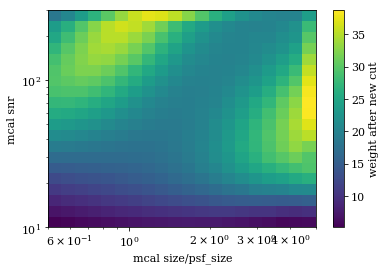

<Figure size 432x288 with 0 Axes>

In [46]:
#logmeshplot(old_w, xedges, yedges, r"weight before new cut")
#plt.figure()
logmeshplot(new_w, xedges, yedges, r"weight after new cut")
plt.figure()
#logmeshplot((new_w-old_w)/old_w, xedges, yedges, r"relative change")
#plt.figure()
#logmeshplot(stored_w, xedges, yedges, r"stored weight")
#plt.figure()
#logmeshplot(stored_w-old_w, xedges, yedges, r"stored - old weight")


In [18]:
# cumulative \sqrt{N}/sigma_gamma

def siggn(e, r, sn, snthresh):
    ok ,= np.where(sn>snthresh)
    sige = np.sqrt(sum(e[ok]**2)/len(ok))
    return np.sqrt(len(ok)) / (sige/np.average(r[ok]))
    

In [19]:
snrs = [10,11,12,13,14,15,16,17,18,19,20,25,30]
stat = []
for s in snrs:
    stat.append(siggn(new_e1,new_R11,new_snr,s))
    #print(stat)

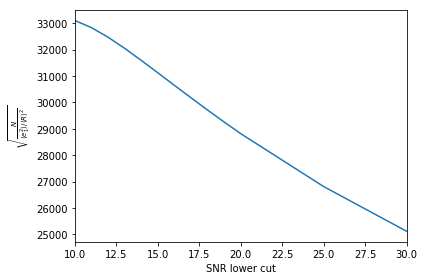

In [20]:
plt.plot(snrs,stat)
plt.xlim(10,30)
#plt.xscale('log')
plt.xlabel("SNR lower cut")
plt.ylabel(r"$\sqrt{\frac{N}{\langle e_1^2\rangle/\langle R\rangle^2}}$")
plt.tight_layout()
plt.savefig("y3_statpower.png",dpi=200)

In [21]:
np.sqrt(  np.sum(new_w**2*new_count*(new_meanes/new_response)**2) / (np.sum(new_w*new_count))**2  )

1.7402839910039336e-05

In [22]:
np.sqrt(  np.sum(new_count*(new_meanes/new_response)**2)      / (np.sum(new_count))**2   )

1.9483930159352275e-05

In [49]:
vsn=[]
vfomw=[]
vfom=[]


for i in range(20):
    sigma=np.sqrt(  np.sum(new_w[:,i:]**2*new_count[:,i:]*(new_meanes[:,i:]/new_response[:,i:])**2) / (np.sum(new_w[:,i:]*new_count[:,i:]))**2  )
    vsn.append(xedges[i])
    vfomw.append(1./sigma**2)
    sigma=np.sqrt(  np.sum(new_count[:,i:]*(new_meanes[:,i:]/new_response[:,i:])**2) / (np.sum(new_count[:,i:]))**2  )
    vfom.append(1./sigma**2)
    
print("The shape noise inverse variance in a mean shear measurement is increased by",np.array(vfomw[0])/np.array(vfom[0]),"through weighting")


vsn=np.array(vsn)
vfom=np.array(vfom)
vfomw=np.array(vfomw)

('The shape noise inverse variance in a mean shear measurement is increased by', 1.2534669230624798, 'through weighting')


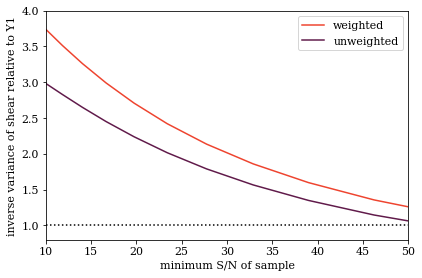

In [54]:
#des scheme
colors = ['#601A4A', '#EE442F','#63ACBE']

from matplotlib import rc
#rc('text', usetex=True)
rc('font', family='serif')
rc('font', size=11)
fontsize='small'

y1=(5.96*1500*3600/0.27**2) # from Zuntz et al


plt.plot(vsn,vfomw/y1,color=colors[1],label="weighted")
plt.plot(vsn,vfom/y1,color=colors[0],label="unweighted")
plt.plot((10,50),(1,1),color="black",linestyle=":")
#plt.xscale('log')
plt.xlim(10,50)
plt.ylim(0.8,4.0)
plt.legend()
plt.xlabel("minimum S/N of sample")
plt.ylabel("inverse variance of shear relative to Y1")
plt.tight_layout()
plt.savefig("invar.pdf")

In [42]:
vfom[0]/

5.966702444819902

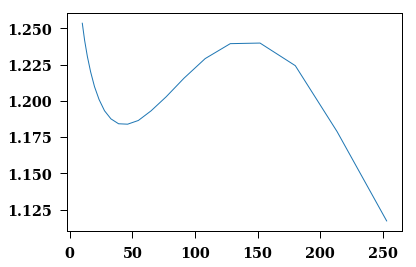

In [187]:

plt.plot(vsn,np.array(vfomw)/np.array(vfom),label="improvement")

Text(0,0.5,'cumulative mean-shear FOM')

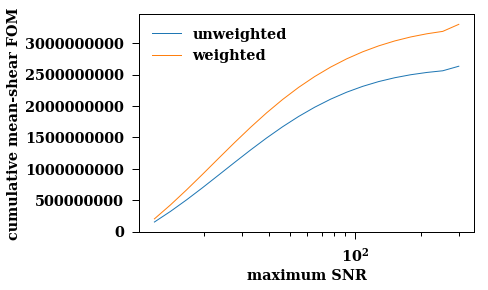

In [194]:
vsn=[]
vfomw=[]
vfom=[]


for i in range(1,21):
    sigma=np.sqrt(  np.sum(new_w[:,:i]**2*new_count[:,:i]*(new_meanes[:,:i]/new_response[:,:i])**2) / (np.sum(new_w[:,:i]*new_count[:,:i]))**2  )
    vsn.append(xedges[i])
    vfomw.append(1./sigma**2)
    sigma=np.sqrt(  np.sum(new_count[:,:i]*(new_meanes[:,:i]/new_response[:,:i])**2) / (np.sum(new_count[:,:i]))**2  )
    vfom.append(1./sigma**2)
    
plt.plot(vsn,vfom,label="unweighted")
plt.plot(vsn,vfomw,label="weighted")
plt.xscale('log')
plt.legend()
plt.xlabel("maximum SNR")
plt.ylabel("cumulative mean-shear FOM")

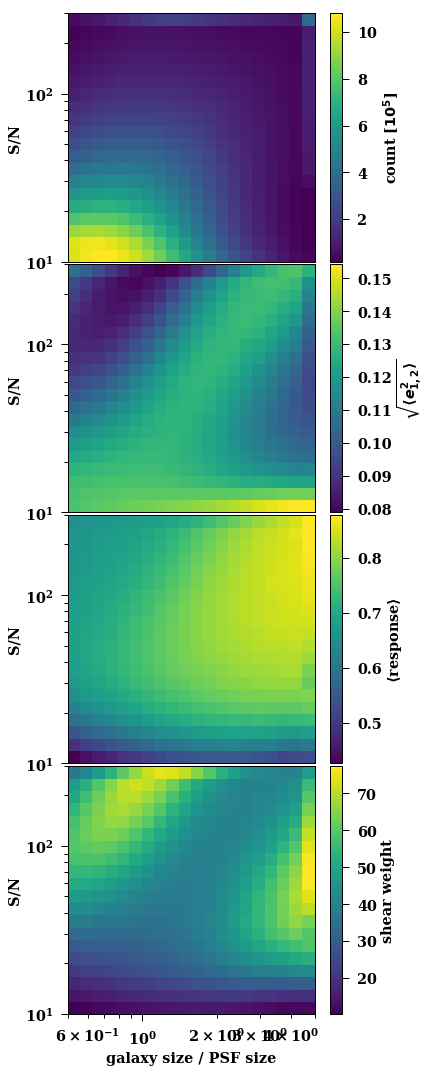

In [204]:
import pylab as mplot
import matplotlib.ticker as ticker

font = {'size'   : 10}
mplot.rc('font', **font)
mplot.rc('text', usetex=False)
mplot.rc('font', family='serif')


fig=plt.figure(figsize=(6,15))
ax = plt.subplot(411)
X, Y = np.meshgrid(yedges, xedges)
im = ax.pcolormesh(X, Y, new_count/1.e5)
plt.xscale('log')
plt.yscale('log')
plt.ylabel("S/N")
#im.colorbar(label="count")
im.axes.get_xaxis().set_visible(False)
fig.colorbar(im, ax=ax, label=r"count [$10^5$]")

ax = plt.subplot(412)
X, Y = np.meshgrid(yedges, xedges)
im = ax.pcolormesh(X, Y, new_meanes)
plt.xscale('log')
plt.yscale('log')
plt.ylabel("S/N")
im.axes.get_xaxis().set_visible(False)
fig.colorbar(im, ax=ax, label=r"$\sqrt{\langle e_{1,2}^2\rangle}$")

ax = plt.subplot(413)
X, Y = np.meshgrid(yedges, xedges)
im = ax.pcolormesh(X, Y, new_response)
plt.xscale('log')
plt.yscale('log')
plt.ylabel("S/N")
im.axes.get_xaxis().set_visible(False)
fig.colorbar(im, ax=ax, label=r"$\langle$response$\rangle$")

ax = plt.subplot(414)
X, Y = np.meshgrid(yedges, xedges)
im = ax.pcolormesh(X, Y, 1/(new_meanes/new_response)**2)

im.axes.get_xaxis().get_ticklabels()[3].set_visible(False)
plt.xscale('log')
plt.yscale('log')
plt.ylabel("S/N")
plt.xlabel("galaxy size / PSF size")
fig.colorbar(im, ax=ax, label="shear weight")

#plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.tight_layout()
plt.subplots_adjust(hspace=0.01)

plt.savefig("/global/u1/d/dgruen/work/Y3_shearcat_tests/Weights/shear_weights.pdf")

In [242]:
import pylab as mplot
import matplotlib.ticker as ticker

font = {'size'   : 10}
mplot.rc('font', **font)
mplot.rc('text', usetex=False)
mplot.rc('font', family='serif')

fig,ax = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(6,15))

X, Y = np.meshgrid(yedges, xedges)
im = ax[0].pcolormesh(X, Y, new_count/1.e5)
plt.xscale('log')
plt.yscale('log')
plt.ylabel("S/N")
#im.colorbar(label="count")
im.axes.get_xaxis().set_visible(False)
c=fig.colorbar(im, ax=ax[0], label=r"count [$10^5$]")

X, Y = np.meshgrid(yedges, xedges)
im = ax[1].pcolormesh(X, Y, new_meanes)
plt.xscale('log')
plt.yscale('log')
plt.ylabel("S/N")
im.axes.get_xaxis().set_visible(False)
c=fig.colorbar(im, ax=ax[1], label=r"$\sqrt{\langle e_{1,2}^2\rangle}$")

X, Y = np.meshgrid(yedges, xedges)
im = ax[2].pcolormesh(X, Y, new_response)
plt.xscale('log')
plt.yscale('log')
plt.ylabel("S/N")
im.axes.get_xaxis().set_visible(False)
c=fig.colorbar(im, ax=ax[2], label=r"$\langle$response$\rangle$")


ax[3].xaxis.set_minor_locator(ticker.NullFormatter())
X, Y = np.meshgrid(yedges, xedges)
ax[3].xaxis.set_minor_locator(ticker.NullFormatter())
im = ax[3].pcolormesh(X, Y, 1/(new_meanes/new_response)**2)
ax[3].xaxis.set_minor_locator(ticker.NullFormatter())
plt.xscale('log')
ax[3].xaxis.set_minor_locator(ticker.NullFormatter())
plt.yscale('log')
#ax[3].xaxis.set_minor_locator(ticker.NullFormatter())
plt.ylabel("S/N")
#ax[3].xaxis.set_minor_locator(ticker.NullFormatter())
plt.xlabel("galaxy size / PSF size")
#ax[3].xaxis.set_minor_locator(ticker.NullFormatter())
c=fig.colorbar(im, ax=ax[3], label="shear weight")
#ax[3].xaxis.set_minor_locator(ticker.NullFormatter())


#plt.tight_layout()
#plt.subplots_adjust(hspace=0.01)
#plt.setp(ax[3].get_xticklabels(), rotation=30, horizontalalignment='right')

Error in callback <function post_execute at 0x2aaadc25c6e0> (for post_execute):


TypeError: __call__() takes at least 2 arguments (1 given)

TypeError: __call__() takes at least 2 arguments (1 given)

<Figure size 432x1080 with 8 Axes>

In [216]:
ax[3].get_xticklabels()

<a list of 5 Text xticklabel objects>

In [217]:
a=ax[3]

In [218]:
a.get_xticks()

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [219]:
yedges

array([0.5       , 0.56100923, 0.62946271, 0.70626877, 0.7924466 ,
       0.88913971, 0.99763116, 1.11936057, 1.25594322, 1.40919147,
       1.58113883, 1.77406695, 1.99053585, 2.23341796, 2.50593617,
       2.81170663, 3.15478672, 3.53972892, 3.97164117, 4.45625469,
       5.        ])

In [226]:
ax[3].xaxis.set_minor_locator(ticker.NullFormatter())